In [61]:
from google.colab import drive
drive.mount('/content/drive')
# Nikhil's working path
%cd drive/My\ Drive/'Captstone(297)'/data
# Selina's working path
# %cd drive/My\ Drive/2020_Fall/'Captstone(297)'/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Captstone(297)/data'
/content/drive/.shortcut-targets-by-id/1auWpfpINZvmJbl0I50kYmpS29bbnesqp/Captstone(297)/data


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

## Web Data

Read in Web Interaction Data - already filtered specifically to interactions available for 5.5k LA listings

In [63]:
df = pd.read_pickle("all_webdata_filtered.pkl")

In [64]:
df.rename({'rexurl':'rexUrl'},axis=1,inplace=True)

In [65]:
print(df.shape)

(4617883, 6)


In [66]:
print('unique users', df['ip'].nunique())
print('unique listings', df['rexUrl'].nunique())
print('total web interactions, LA',df.shape)

unique users 92071
unique listings 533
total web interactions, LA (4617883, 6)


## Listing Data

In [67]:
listing_data = pd.read_pickle('LOG_siamese_data_11_12.pkl')
listing_data.head(2)

,rex_url,total_baths,stories,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,bedrooms,full_baths,half_baths,year_built,latitude,longitude,is_apt,hotness_score,demand_score,supply_score,ldpviews_per_property_vs_us,loc_tsne_1,loc_tsne_2,1hot_marketing_budget_LOW,1hot_marketing_budget_MEDIUM,1hot_marketing_budget_SURGE,1hot_property_type_CONDO,1hot_property_type_COOP,1hot_property_type_MULTI_FAMILY,1hot_property_type_SINGLE,1hot_property_type_TOWNHOUSE,1hot_pool_spa_types_Community Pool or Spa,1hot_pool_spa_types_Heated Pool,1hot_pool_spa_types_In Ground,1hot_pool_spa_types_No,1hot_pool_spa_types_Pool & Spa (both),1hot_pool_spa_types_Pool (yes),1hot_pool_spa_types_Spa (only),1hot_home_style_Bungalow,1hot_home_style_Cape Cod,1hot_home_style_Contemporary,1hot_home_style_Mediterranean,1hot_home_style_Modern,1hot_home_style_Other,1hot_home_style_Ranch/Rambler,1hot_home_style_Spanish,1hot_home_style_Traditional,1hot_fencing_description_Average Condition,1hot_fencing_description_Back Yard,1hot_fencing_description_Block,1hot_fencing_description_Block Wall,1hot_fencing_description_Chain Link,1hot_fencing_description_Excellent Condition,1hot_fencing_description_Good Condition,1hot_fencing_description_None,1hot_fencing_description_Other,1hot_fencing_description_Other/Remarks,1hot_fencing_description_Partial,1hot_fencing_description_Privacy,1hot_fencing_description_Stucco Wall,1hot_fencing_description_Vinyl,1hot_fencing_description_Wood,1hot_fencing_description_Wrought Iron,1hot_property_condition_Additions/Alter,1hot_property_condition_Additions/Alterations,1hot_property_condition_Building Permit,1hot_property_condition_Fixer,1hot_property_condition_Other,1hot_property_condition_Repairs Cosmetic,1hot_property_condition_Repairs Major,1hot_property_condition_Termite Clearance,1hot_property_condition_Turnkey,1hot_property_condition_Updated/Remodeled,log_price,log_sqft,log_median_listing_price,log_median_days_on_market,log_nielsen_hh_rank,log_land_sqft,log_total_rooms
0,rex1-pacific-coast-hwy,12.0,1,0,0,0,0,0,12.0,2.0,0.0,2015.0,34.023865,-118.787080,0.0,23.044945,44.348576,1.741313,0.9191,4.173980,6.034126,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,17.599700,9.350972,15.404756,5.398163,8.734077,11.860550,3.496508
1,4080-glencoe-ave-unit-316,2.0,1,0,0,0,0,0,1.0,2.0,0.0,2011.0,33.990732,-118.441965,1.0,6.741705,3.992470,9.490940,0.2721,9.119221,13.400335,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.909911,7.365180,14.143410,4.663439,7.694393,9.760541,1.609438


In [68]:
df_web_la = df.copy()
# removed because new webdata was already filtered to only being from these LA listings
# df_web_la = df_web_la[df_web_la.rexUrl.isin(list(set(listing_data.rex_url)))]

In [69]:
print('Unique LA listings',len(set(listing_data.rex_url)))
print('Unique LA listings with webdata',len(set(df_web_la.rexUrl)))

Unique LA listings 5575
Unique LA listings with webdata 533


In [70]:
# Convert eventstamp to datetime
df_web_la['event_stamp'] = pd.to_datetime(df_web_la['event_stamp'])

#sort by ip and eventstamp
df_web_la.sort_values(['ip','event_stamp'],ascending=True,inplace=True)

Visualize number of interactions by ip

In [71]:
houses_per_ip = df_web_la.groupby('ip')['rexUrl'].aggregate('nunique').value_counts(normalize=True)

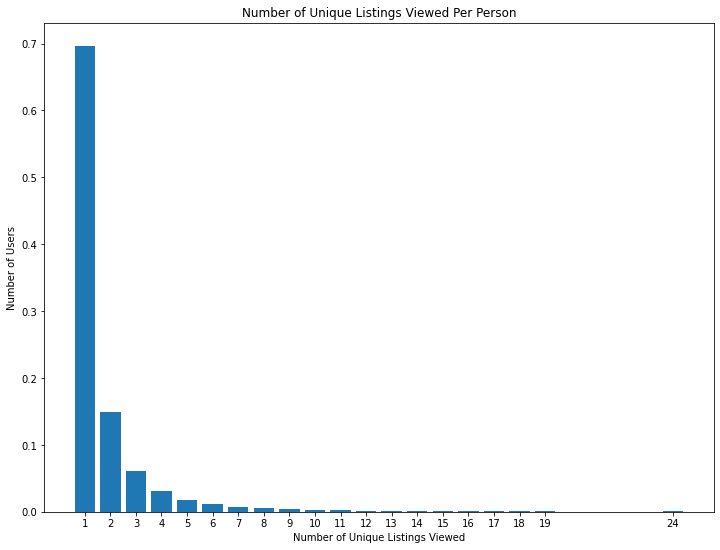

In [72]:
sub_houses_per_ip = houses_per_ip.head(20)
plt.figure(figsize=(12,9))
plt.bar(x=sub_houses_per_ip.index, height=sub_houses_per_ip.values)
plt.xticks(sub_houses_per_ip.index)
# xlocs, xlabs = plt.xticks()
# for i, v in enumerate(sub_houses_per_ip.values):
#   plt.text(xlocs[i], v+3, str(v),horizontalalignment="center")
plt.title('Number of Unique Listings Viewed Per Person')
plt.xlabel('Number of Unique Listings Viewed')
plt.ylabel('Number of Users')
plt.show()

# Co-occ windows

In [73]:
from collections import OrderedDict

In [74]:
# get the set of listings viewed by each user
rex_list_each_user = df_web_la.groupby('ip')['rexUrl'].apply(lambda x: list(OrderedDict.fromkeys(x))).values.tolist()
rex_list_each_user[:10]

# # convert each into a list
# rex_set_each_user = [] 
# [rex_set_each_user.append(x) for x in rex_set_each_user_pre if x not in rex_set_each_user] 
# # rex_list_each_user = [list(i) for i in rex_set_each_user]


[['28710-indies-ln-canyon-country'],
 ['23552-park-south-st'],
 ['9235-garibaldi-ave'],
 ['9323-alcott-st-apt-101', '1050-trevecca-pl'],
 ['3501-knoll-crest-ave'],
 ['2463-corralitas-dr'],
 ['1050-trevecca-pl', '9735-baden-ave'],
 ['14919-cadillac-ct'],
 ['1534-amherst-ave-apt-302'],
 ['850-e-ocean-blvd-apt-607']]

In [75]:
# Old version not preserving order

# # # get the set of listings viewed by each user
# rex_set_each_user = df_web_la.groupby('ip')['rexUrl'].apply(set).values
# # convert each into a list
# rex_list_each_user = [list(i) for i in rex_set_each_user]
# rex_list_each_user[:10]

In [76]:
# the length of the list should be the number of users
print(len(rex_list_each_user))
print(df_web_la.ip.nunique())

92071
92071


In [77]:
# Get a dictionary of listings each house Co-Occured with (within a window)
from collections import Counter
from collections import defaultdict

window_occurences = defaultdict(Counter)

#loop through  of all viewings for a user
for viewings_user_curr in rex_list_each_user:
  #for each house in list of viewings
    for i, listing in enumerate(viewings_user_curr):
      # Set window as one before and one ahead
      window = viewings_user_curr[max(0,i-1):i+3].copy()
      #remove self
      while listing in window:
        window.remove(listing) 
      
      # update the dict of current listing with this window of co-occurances
      window_occurences[listing].update(window)

In [78]:
# Remove empty dict elements (when listing didn't co-occur with any)
window_occurences = {k: v for k, v in dict(window_occurences).items() if v}

In [79]:
print(len(window_occurences), 'listings ever co-occured with others')

504 listings ever co-occured with others


In [80]:
len(window_occurences['1017-janette-st'])

85

In [81]:
def view_co_ocs(anchor,df_in):
  pd.options.display.float_format = '{:,.1f}'.format
  df = df_in.copy()
  df['sqft'] = np.exp(df['log_sqft'])
  df['price'] = np.exp(df['log_price'])
  df['total_rooms'] = np.exp(df['log_total_rooms'])
  cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

  cooc_df = pd.DataFrame.from_dict(dict(window_occurences[anchor]),orient='index').reset_index().rename({'index':'rex_url',0:'cooc_count'},axis=1)

  cooc_data = cooc_df.merge(df,on='rex_url',how='left')[cols+['cooc_count']].set_index('rex_url')

  cooc_data.sort_values('cooc_count',ascending=False,inplace=True)
  anchor_row = df[df.rex_url==anchor][cols].set_index('rex_url')


  return pd.concat([anchor_row, cooc_data])

In [82]:
converse_street_coocs = view_co_ocs('4799-converse-st',listing_data)
converse_street_coocs['ppsqft'] = converse_street_coocs['price']/converse_street_coocs['sqft']
converse_street_coocs.head(15)

,sqft,price,bedrooms,total_rooms,full_baths,is_apt,cooc_count,ppsqft
rex_url,,,,,,,,
4799-converse-st,812.0,"600,000.0",2.0,5.0,1.0,0.0,nan,738.9
244-s-avenue-24,972.0,"450,000.0",2.0,5.0,1.0,0.0,30.0,463.0
814-e-graves-ave,"1,126.0","635,000.0",3.0,7.0,2.0,0.0,13.0,563.9
945-acacia-ln,"1,300.0","470,000.0",2.0,5.0,3.0,0.0,8.0,361.5
17719-posetano-rd,"2,500.0","3,550,000.0",3.0,6.0,3.0,0.0,8.0,"1,420.0"
1501-camulos-ave,"2,112.0","1,288,000.0",3.0,10.0,3.0,0.0,8.0,609.8
6345-colbath-ave,"1,633.0","779,000.0",3.0,7.0,2.0,0.0,8.0,477.0
14833-canna-valley-st,"1,263.0","535,000.0",3.0,5.0,2.0,0.0,7.0,423.6
1238-valiant-st,"2,792.0","435,000.0",5.0,8.0,3.0,0.0,7.0,155.8


# Triplets

In [83]:
all_houses = list(set(df_web_la['rexUrl']))

In [84]:
from itertools import repeat
import random
random.seed(297)
co_occurences = window_occurences.copy()

# Creating a dictionary, where each key is a listing, and the values are a list of other houses it has appeared with
# houses that it has appeared with multiple times are repeated

listing_cooc_dict = {}
listing_neg_dict = {}

for housename in list(co_occurences.keys()):
  # Set of listings it appeared with
  appeared_with = list(co_occurences[housename].keys())

  # Ordered tuple pairings of listings it appeared with
  sorted_cooc_tuples = co_occurences[housename].most_common()
  cooc_rep_list = []
  for other_listing, count_together in sorted_cooc_tuples:
    if(other_listing==housename):
      continue
    else:
      repeated = list(repeat(other_listing,count_together))
      cooc_rep_list.extend(repeated)

  
  # Set of listings it didn't appear with
  appeared_with.append(housename)
  didnt_appear_with = list(set(all_houses)-set(appeared_with))
  n_appearswith = len(cooc_rep_list)
  n_didntappearwith = len(didnt_appear_with)
  
  #if appeared with more than didnt appear with, swap them so you can still sample
  if(n_didntappearwith<n_appearswith):
    n_appearswith = n_didntappearwith

  sample_nocooc = random.sample(didnt_appear_with,n_appearswith)

  listing_cooc_dict[housename] = cooc_rep_list
  listing_neg_dict[housename] = sample_nocooc



In [85]:
# Compile list of triplets
triplets = []
for listing in listing_cooc_dict.keys():
  #if list is empty (no coocs), dont add it
  if not listing_cooc_dict[listing]:
    continue
  for pos, neg in zip(listing_cooc_dict[listing],listing_neg_dict[listing]):
    triplets.append([listing,pos,neg])

In [86]:
triplets_df = pd.DataFrame(triplets, columns = ['anchor', 'positive','negative'])
print(triplets_df.shape)
triplets_df.tail(10)

(81584, 3)


,anchor,positive,negative
81574,18543-victory-blvd,1330-s-ynez-ave,19250-knapp-st
81575,2307-ashland-ave,8719-topanga-canyon-blvd,21857-alamogordo-rd
81576,2307-ashland-ave,5902-finecrest-dr,7250-franklin-ave-unit-303
81577,2307-ashland-ave,1417-e-maple-st,18645-hatteras-st-unit-174
81578,28710-indies-ln,16321-janine-dr,1120-n-dixie-dr
81579,28710-indies-ln,8450-denise-ln,24453-brook-ct
81580,28710-indies-ln,1506-lynoak-dr,11218-camarillo-st-apt-104
81581,14033-mar-vista-st,15225-santa-gertrudes-ave-apt-p104,2227-e-alaska-st
81582,14033-mar-vista-st,945-acacia-ln,22010-barrington-way
81583,14033-mar-vista-st,814-e-graves-ave,19423-radlett-ave


In [87]:
triplets_df[triplets_df.anchor==triplets_df.negative]

,anchor,positive,negative


In [88]:
triplets_df[triplets_df.anchor==triplets_df.positive]

,anchor,positive,negative


In [89]:
triplets_df[triplets_df.positive==triplets_df.negative]

,anchor,positive,negative


In [90]:
triplets_df.anchor.nunique()

504

In [91]:
# triplets_df.to_csv("triplets_LA.csv", index=False)

## Case study check

In [93]:
triplets_df[triplets_df.anchor=='5506-softwind-way']

,anchor,positive,negative
78773,5506-softwind-way,9619-rex-rd,23360-happy-valley-dr
78774,5506-softwind-way,9619-rex-rd,15729-celtic-st
78775,5506-softwind-way,6345-colbath-ave,2003-w-115th-st
78776,5506-softwind-way,16321-janine-dr,6209-pacific-ave-unit-101
78777,5506-softwind-way,535-geneva-st,844-e-meadbrook-st
78778,5506-softwind-way,1215-e-carson-st-apt-20,26106-alizia-canyon-dr-unit-f
78779,5506-softwind-way,8520-wilbur-ave,19348-laroda-ln
78780,5506-softwind-way,623-n-lucerne-blvd,126-e-80th-st
78781,5506-softwind-way,124-n-canyon-blvd,8313-cheyenne-st
78782,5506-softwind-way,3640-candor-st,15259-golden-ct


In [94]:
co_occurences['5506-softwind-way'].most_common()

[('9619-rex-rd', 2),
 ('6345-colbath-ave', 1),
 ('16321-janine-dr', 1),
 ('535-geneva-st', 1),
 ('1215-e-carson-st-apt-20', 1),
 ('8520-wilbur-ave', 1),
 ('623-n-lucerne-blvd', 1),
 ('124-n-canyon-blvd', 1),
 ('3640-candor-st', 1),
 ('20131-romar-st', 1),
 ('3001-hollywell-pl', 1),
 ('1507-benedict-ave', 1),
 ('10029-nevada-ave', 1),
 ('13815-lubican-st', 1),
 ('7800-topanga-canyon-blvd-apt-201', 1),
 ('36144-37th-st-e', 1),
 ('1112-poppy-dr', 1),
 ('9323-alcott-st-apt-101', 1),
 ('1517-s-van-ness-ave', 1),
 ('5861-parkmor-rd', 1),
 ('18724-vista-del-canon-unit-b', 1),
 ('5500-lindley-ave-unit-224', 1),
 ('5268-lindley-ave', 1),
 ('18730-hatteras-st-unit-16', 1)]

## Bring in processed LA data

In [95]:
listing_rexurl = listing_data.copy()
listing_rexurl.set_index('rex_url',inplace=True)

In [96]:
listing_dict = listing_rexurl.to_dict(orient='index')

In [97]:
# import pickle

# # save co-occurance house
# f = open("listing_cooc_dict.pkl","wb")
# pickle.dump(listing_cooc_dict,f)
# f.close()

# # save house features
# f = open("listing_dict.pkl","wb")
# pickle.dump(listing_dict,f)
# f.close()

In [98]:
triplets_data = triplets_df.copy()
miss_list=[]

anchor_list = []
pos_list = []
neg_list = []

for idx, row in triplets_data.iterrows():
  anchor_data = listing_dict.get((row['anchor']))
  pos_data = listing_dict.get(row['positive'])
  neg_data = listing_dict.get(row['negative'])

  if(None in [anchor_data, pos_data, neg_data]):
    miss_list.append(idx)

  else:
    # print(anchor_data)
    row['anchor'] = list(anchor_data.values())
    anchor_list.append(list(anchor_data.values()))

    row['positive'] = list(pos_data.values())
    pos_list.append(list(pos_data.values()))

    row['negative'] = list(neg_data.values())
    neg_list.append(list(neg_data.values()))


In [99]:
miss_list

[]

In [100]:
triplets_data.drop(index=miss_list,inplace=True)

In [101]:
triplets_data.head()

,anchor,positive,negative
0,"[3.0, 2, 0, 1, 1, 0, 1, 3.0, 3.0, 0.0, 1966.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1948.0,...","[2.0, 1, 1, 1, 1, 0, 1, 3.0, 2.0, 0.0, 1998.0,..."
1,"[3.0, 2, 0, 1, 1, 0, 1, 3.0, 3.0, 0.0, 1966.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1948.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1969.0,..."
2,"[3.0, 2, 0, 1, 1, 0, 1, 3.0, 3.0, 0.0, 1966.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1948.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1952.0,..."
3,"[3.0, 2, 0, 1, 1, 0, 1, 3.0, 3.0, 0.0, 1966.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1948.0,...","[3.0, 2, 0, 0, 0, 0, 0, 4.0, 3.0, 0.0, 1986.0,..."
4,"[3.0, 2, 0, 1, 1, 0, 1, 3.0, 3.0, 0.0, 1966.0,...","[2.0, 1, 0, 0, 0, 0, 0, 3.0, 2.0, 0.0, 1948.0,...","[2.0, 1, 0, 0, 0, 0, 0, 2.0, 2.0, 0.0, 1941.0,..."


In [102]:
triplets_data.shape

(81584, 3)

In [103]:
np.save('anchor_data_window_3fix',np.array(anchor_list))
np.save('pos_data_window_3fix',np.array(pos_list))
np.save('neg_data_window_3fix',np.array(neg_list))

# np.save('anchor_data_window_full',np.array(anchor_list))
# np.save('pos_data_window_full',np.array(pos_list))
# np.save('neg_data_window_full',np.array(neg_list))

# np.save('anchor_data_3window_full',np.array(anchor_list))
# np.save('pos_data_3window_full',np.array(pos_list))
# np.save('neg_data_3window_full',np.array(neg_list))

In [104]:
import pickle

with open('listing_cooc_3fix.pkl', 'wb') as handle:
    pickle.dump(listing_cooc_dict,handle)

##Pairings (anchor-pos, anchor-neg) for Tree

In [105]:
triplets_df.head()

,anchor,positive,negative
0,28710-indies-ln-canyon-country,6345-colbath-ave,4335-penca-ave
1,28710-indies-ln-canyon-country,6345-colbath-ave,5506-softwind-way
2,28710-indies-ln-canyon-country,6345-colbath-ave,6025-fallbrook-ave
3,28710-indies-ln-canyon-country,6345-colbath-ave,23360-happy-valley-dr
4,28710-indies-ln-canyon-country,6345-colbath-ave,930-ohio-ave


In [106]:
no_dups = triplets_df.copy()
no_dups.drop_duplicates(['anchor','positive'],inplace=True)

In [107]:
positive_pairs = no_dups[['anchor','positive']].copy()
positive_pairs = positive_pairs.merge(listing_data,left_on='anchor',right_on='rex_url')
positive_pairs = positive_pairs.merge(listing_data,left_on='positive',right_on='rex_url',suffixes=('_anchor','_pair'))
positive_pairs.drop(['rex_url_anchor','rex_url_pair'],axis=1,inplace=True)
positive_pairs.shape

(16678, 156)

In [108]:
negative_pairs = no_dups[['anchor','negative']].copy()
negative_pairs = negative_pairs.merge(listing_data,left_on='anchor',right_on='rex_url')
negative_pairs = negative_pairs.merge(listing_data,left_on='negative',right_on='rex_url',suffixes=('_anchor','_pair'))
negative_pairs.drop(['rex_url_anchor','rex_url_pair'],axis=1,inplace=True)
negative_pairs.shape

(16678, 156)

In [109]:
positive_pairs.to_pickle('positive_pairs_3fix.pkl')
negative_pairs.to_pickle('negative_pairs_3fix.pkl')

# positive_pairs.to_pickle('positive_3pairs_full.pkl')
# negative_pairs.to_pickle('negative_3pairs_full.pkl')

### Keep duplicates

In [110]:
positive_pairs_w = triplets_df[['anchor','positive']].copy()
positive_pairs_w = positive_pairs_w.merge(listing_data,left_on='anchor',right_on='rex_url')
positive_pairs_w = positive_pairs_w.merge(listing_data,left_on='positive',right_on='rex_url',suffixes=('_anchor','_pair'))
positive_pairs_w.drop(['rex_url_anchor','rex_url_pair'],axis=1,inplace=True)
positive_pairs_w.shape

(81584, 156)

In [111]:
negative_pairs_w = triplets_df[['anchor','negative']].copy()
negative_pairs_w = negative_pairs_w.merge(listing_data,left_on='anchor',right_on='rex_url')
negative_pairs_w = negative_pairs_w.merge(listing_data,left_on='negative',right_on='rex_url',suffixes=('_anchor','_pair'))
negative_pairs_w.drop(['rex_url_anchor','rex_url_pair'],axis=1,inplace=True)
negative_pairs_w.shape

(81584, 156)

In [112]:
positive_pairs_w.to_pickle('positive_pairs_3fix_wdups.pkl')
negative_pairs_w.to_pickle('negative_pairs_3fix_wdups.pkl')

# positive_pairs_w.to_pickle('positive_3pairs_full_wdups.pkl')
# negative_pairs_w.to_pickle('negative_3pairs_full_wdups.pkl')